In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import spacy
nlp = spacy.load('en_core_web_lg')

<center><h1>Character Embeddings for Text Classification</h1></center>

character level embedding can be very helpful as it tends to solve the typos issues and out of vocabulary words.

<center><img src="https://www.researchgate.net/profile/Hoang_Pham26/publication/316875275/figure/fig1/AS:493031154556929@1494559195862/The-CNN-for-extracting-character-level-features-of-word-Hoc-sinh-Student.png"></center>

In [16]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer
stop=nltk.corpus.stopwords.words('english')

In [17]:
# creat tag map between treebank and wordnet
# tree bank : collection of syntactically annotated sentences
tag_map = {
"CC": None, #formatted. conjunction (and, but, or)
'CD': wn.NOUN, # original number (one,two)
'DT': None, # delimiter (a, the)
'EX': wn.ADV, #and my "there" (there)
"FW": None, # foreign word (mea culpa)
"IN": wn.ADV,# preposition/subjunctive conjunction (of, in,by) 
'JJ': [wn.ADJ, wn.ADJ_SAT],# adjective # (yellow)
'JJR': [wn.ADJ, wn.ADJ_SAT], # add, comparator (larger)
"JJS": [wn.ADJ, wn.ADJ_SAT], # add, superlative (wildest)
"LS": None, #list item tag(1,2,One)
'MD': None, # modal (can, should)
'NN': wn.NOUN, #noun, sing. or nugget (llama)
'NNS': wn.NOUN, #noun, plural (Llamas)
"NNP": wn.NOUN, # proper noun, vocals. (IBM)
'NNPS': wn.NOUN, # proper noun, plural (Carolina)
"PDT": [wn.ADJ, wn.ADJ_SAT], # predeterminer (all, both)
'POS':None, # end of ownership
'PRP': None, # personal pronoun (I, you, he)
'prp$': None, # possessive pronoun (your, one's)
"RB": wn.ADV, #adv (quickly, never)
'RBR': wn.ADV, # adverb, comparative (faster)
'RBS':wn.ADV,# adverb, superlative (fastest)
'RP': [wn.ADJ, wn.ADJ_SAT], # particle (up, off)
'SYM': None, #symbol, # (+, %, &)
'TO': None, # 'to' (to)
'UH': None, # interjection (uh, oops)
'VB': wn.VERB,# verb base form # (eat)
'VBD': wn.VERB, # verb past tense (eat)
'VBG': wn.VERB, #verb gerund (to eat)
'VBN': wn.VERB, # past participle (eaten)
"VBP": wn.VERB, #non-3sg pres verb (eat)
'VBZ': wn.VERB,# verb зsg pres (egts) 
}

In [18]:
lemma=WordNetLemmatizer()
def get_lemma(text):
    l=[]
    tags=pos_tag(text.split())
    for token,tag in tags:
        try:
             l.append(lemma.lemmatize(token,pos=tag_map[tag][0]))
        except:
            continue
    return l

In [19]:
from termcolor import colored
def cleaning(df):
    """
    - remove empty strings
    - remove duplicates
    """
    # remove empty string
    blanks=[]
    for i ,v in df.itertuples():
        if v.isspace() ==True or v=='':
            blanks.append(i)
    if len(blanks)>0:
        df=df.drop(blanks)
        print(f"found {colored(len(blanks),'red')} blanks")
    else:
        print("no blanks found")

    # remove duplicates
    if df.duplicated().sum() !=0:
        print(f"dropped {colored(df.duplicated().sum(),'red')} : values")
        df=df.drop_duplicates()
    else:
        print("no duplicates found")
    return df

In [20]:
import re
import string
def preprocessing(df,col):
    # lowercasing
    df[col]=df[col].apply(lambda x: " ".join(t.lower() for t in x.split()))
    # remove emails
    df[col]=df[col].apply(lambda x: re.sub("\S+\@\S+",'',x))
    # remove URls
    df[col]=df[col].apply(lambda x: re.sub("\S+\.\S+",'',x))
    # remove punctations
    df[col]=df[col].apply(lambda x: re.sub(f'[{re.escape(string.punctuation)}]',' ',x))
    # remove stopwords
    df[col]=df[col].apply(lambda x :" ".join(t for t in x.lower().split() if t not in stop))
    # remove \n or \t
    df[col]=df[col].apply(lambda x: re.sub('\n|\t',' ',x))
    # remove 2 characters words
    df[col]=df[col].apply(lambda x: re.sub(r' \w\w ',' ',x) )
    # remove 1 character words
    df[col]=df[col].apply(lambda x: re.sub(r' \w ',' ',x) )
    # remove extra spaces more than or equals "2" 
    df[col]=df[col].apply(lambda x: re.sub(" {2,}",' ',x))
    # select alphapetical only
    df[col]=df[col].apply(lambda x: re.sub("[^a-z]+",' ',x) )
    # strip string
    df[col]=df[col].apply(lambda x: x.strip())
    # get lemma
    df[col]=df[col].apply(lambda x: " ".join(get_lemma(x)))
    return df

In [21]:
# remove empty strings  
# remove duplicates 
# remove 1 character words
# remove 2 characters words

In [22]:
df=pd.read_csv(r'smsspamcollection.tsv',sep='\t')

In [23]:
x=df['message']
y=df['label']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.33,random_state=42)

In [25]:
x_train=pd.DataFrame(X_train,columns=['message'])
x_test=pd.DataFrame(X_test,columns=['message'])

In [26]:
cleaned_train=cleaning(x_train)
cleaned_test=cleaning(x_test)

no blanks found
dropped 210 : values
no blanks found
dropped 65 : values


In [27]:
import warnings
warnings.filterwarnings('ignore')

In [28]:
prep_train=preprocessing(cleaned_train,col='message')
prep_test=preprocessing(cleaned_test,col='message')

In [29]:
y_train=y_train[prep_train.index]
y_test=y_test[prep_test.index]

In [30]:
def get_longest_seq(texts):
    longest=0
    for text in texts:
        text_len=len(text)
        longest=max(text_len,longest)
    return longest

In [31]:
longest_input=get_longest_seq(prep_train['message'])
longest_input

378

In [2]:
import string

In [3]:
unique_chars = len(string.ascii_letters+string.digits)
unique_chars.

62

In [34]:
from collections import defaultdict
char2idx = defaultdict(lambda:0)

In [35]:
char2idx

defaultdict(<function __main__.<lambda>()>, {})

In [36]:
for idx, char in enumerate(string.ascii_letters+string.digits, 1):
    char2idx[char] = idx

In [38]:
def encode_text(text):
    text_v = np.zeros((longest_input, unique_chars))
    for i, char in enumerate(text):
        if i<longest_input:
            text_v[i, char2idx[char]] = 1
    return text_v 

In [39]:
encode_text("aahelo")

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], shape=(378, 62))

In [40]:
def encode_texts(texts):
    # (None,378,62)
    text_v = np.zeros((len(texts), longest_input, unique_chars))
    for i, text in enumerate(texts):
        text_v[i] = encode_text(text)
    return text_v

In [41]:
train_encoded=encode_texts(prep_train['message'])
test_encoded=encode_texts(prep_test['message'])

In [42]:
train_encoded.shape

(3523, 378, 62)

In [43]:
from sklearn.preprocessing import LabelEncoder
lb=LabelEncoder()
y_train=lb.fit_transform(y_train)
y_test=lb.transform(y_test)

In [44]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Reshape,Conv2D,MaxPool2D,Flatten,Dense,concatenate
from tensorflow.keras.models import Model

In [45]:
inputs = Input((longest_input, unique_chars))

In [46]:
reshaped=Reshape((longest_input, unique_chars,1))(inputs)

In [48]:
reshaped

<KerasTensor shape=(None, 378, 62, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_1>

In [49]:
# kernels = [9,7]
# kernels_2 = [5,3]

# # ((n-f+2p)/s)+1
# conv_1=[]
# for kernel in kernels:
#     conv=Conv2D(50,(kernel,unique_chars),activation='relu')(reshaped)#input(N,378,62,1)-->output(N,377,1,50) 
#     pool=MaxPool2D(pool_size=(kernel,1),strides=1)(conv)#input(N,65,1,100) -->output(N,1,1,100)
#     conv_1.append(pool)
# # characters level features
# merge=concatenate(conv_1,axis=1)

# conv_2=[]
# for kernel in kernels_2:
#     conv=Conv2D(100,(kernel,1),activation='relu')(merge)#input(N,378,62,1)-->output(N,377,1,50) 
#     pool=MaxPool2D(pool_size=(kernel,1),strides=1)(conv)#input(N,65,1,100) -->output(N,1,1,100)
#     conv_2.append(pool)

# # words level features
# merge_2=concatenate(conv_2,axis=1)

# flatten=Flatten()(merge_2)

In [51]:
filters = [2, 3, 4]
# ((n-f+2p)/s)+1
conv_1=Conv2D(100,(filters[0],unique_chars),activation='relu')(reshaped)#input(N,66,300,1)-->output(N,65,1,100) 
conv_2=Conv2D(100,(filters[1],unique_chars),activation='relu')(reshaped)
conv_3=Conv2D(100,(filters[2],unique_chars),activation='relu')(reshaped)

pool_1=MaxPool2D(pool_size=(filters[0],1),strides=1)(conv_1)#input(N,65,1,100) -->output(N,1,1,100)
pool_2=MaxPool2D(pool_size=(filters[1],1),strides=1)(conv_2)
pool_3=MaxPool2D(pool_size=(filters[2],1),strides=1)(conv_3)

merged=concatenate([pool_1,pool_2,pool_3],axis=1)

flatten=Flatten()(merged)

In [52]:
dense=Dense(100,activation='relu')(flatten)

In [53]:
outputs=Dense(1,activation='sigmoid')(dense)

In [54]:
model=Model(inputs=inputs,outputs=outputs)

In [55]:
model.compile(optimizer=tf.keras.optimizers.Adam(),loss=tf.keras.losses.binary_crossentropy,metrics=['acc'])

In [56]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 378, 62)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 378, 62, 1)        │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 377, 1, 100)       │          12,500 │ reshape[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 376, 1, 100)       │          18,700 │ reshape[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 375, 1, 100)       │          24,900 │ reshape[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 376, 1, 100)       │               0 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 374, 1, 100)       │               0 │ conv2d_2[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_2               │ (None, 372, 1, 100)       │               0 │ conv2d_3[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 1122, 1, 100)      │               0 │ max_pooling2d[0][0],       │
│                               │                           │                 │ max_pooling2d_1[0][0],     │
│                               │                           │                 │ max_pooling2d_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten (Flatten)             │ (None, 112200)            │               0 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense (Dense)                 │ (None, 100)               │      11,220,100 │ flatten[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_1 (Dense)               │ (None, 1)                 │             101 │ dense[0][0]                │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 11,276,301 (43.02 MB)

 Trainable params: 11,276,301 (43.02 MB)

 Non-trainable params: 0 (0.00 B)

In [118]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 378, 62)           │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ reshape (Reshape)             │ (None, 378, 62, 1)        │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_31 (Conv2D)            │ (None, 370, 1, 50)        │          27,950 │ reshape[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_32 (Conv2D)            │ (None, 372, 1, 50)        │          21,750 │ reshape[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_30              │ (None, 362, 1, 50)        │               0 │ conv2d_31[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_31              │ (None, 366, 1, 50)        │               0 │ conv2d_32[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_12 (Concatenate)  │ (None, 728, 1, 50)        │               0 │ max_pooling2d_30[0][0],    │
│                               │                           │                 │ max_pooling2d_31[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_33 (Conv2D)            │ (None, 724, 1, 100)       │          25,100 │ concatenate_12[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_34 (Conv2D)            │ (None, 726, 1, 100)       │          15,100 │ concatenate_12[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_32              │ (None, 720, 1, 100)       │               0 │ conv2d_33[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_33              │ (None, 724, 1, 100)       │               0 │ conv2d_34[0][0]            │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_13 (Concatenate)  │ (None, 1444, 1, 100)      │               0 │ max_pooling2d_32[0][0],    │
│                               │                           │                 │ max_pooling2d_33[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ flatten_6 (Flatten)           │ (None, 144400)            │               0 │ concatenate_13[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_8 (Dense)               │ (None, 100)               │      14,440,100 │ flatten_6[0][0]            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 14,530,101 (55.43 MB)

 Trainable params: 14,530,101 (55.43 MB)

 Non-trainable params: 0 (0.00 B)

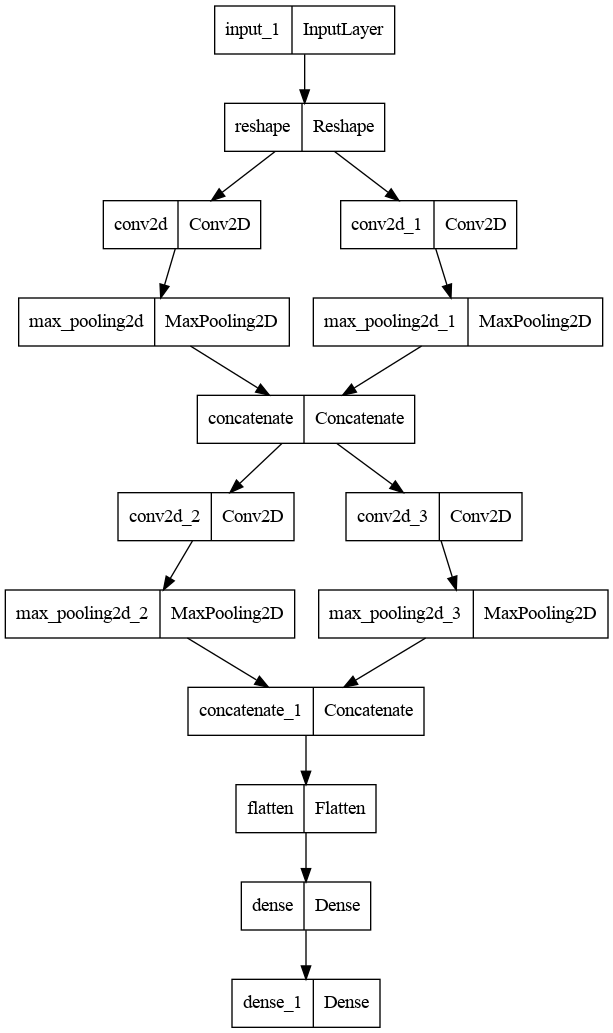

In [57]:
history=model.fit(train_encoded,y_train,epochs=5,batch_size=64,validation_split=0.2,verbose=1)

Epoch 1/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 298ms/step - acc: 0.8801 - loss: 0.2826 - val_acc: 0.9291 - val_loss: 0.2220
Epoch 2/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 289ms/step - acc: 0.9464 - loss: 0.1613 - val_acc: 0.9489 - val_loss: 0.1469
Epoch 3/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 275ms/step - acc: 0.9723 - loss: 0.0919 - val_acc: 0.9532 - val_loss: 0.1329
Epoch 4/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 12s 272ms/step - acc: 0.9883 - loss: 0.0469 - val_acc: 0.9489 - val_loss: 0.1717
Epoch 5/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 280ms/step - acc: 0.9915 - loss: 0.0345 - val_acc: 0.9574 - val_loss: 0.1166


In [119]:
history=model.fit(train_encoded,y_train,epochs=5,batch_size=64,validation_split=0.2,verbose=1)

Epoch 1/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 352ms/step - acc: 0.8769 - loss: 0.2939 - val_acc: 0.8624 - val_loss: 0.2913
Epoch 2/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 361ms/step - acc: 0.9361 - loss: 0.1712 - val_acc: 0.9589 - val_loss: 0.1483
Epoch 3/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 363ms/step - acc: 0.9734 - loss: 0.0731 - val_acc: 0.9645 - val_loss: 0.1166
Epoch 4/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 16s 363ms/step - acc: 0.9933 - loss: 0.0250 - val_acc: 0.9603 - val_loss: 0.1687
Epoch 5/5
45/45 ━━━━━━━━━━━━━━━━━━━━ 17s 372ms/step - acc: 0.9982 - loss: 0.0075 - val_acc: 0.9603 - val_loss: 0.1645


In [58]:
training_accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']

training_loss = history.history['loss']
validation_loss = history.history['val_loss']

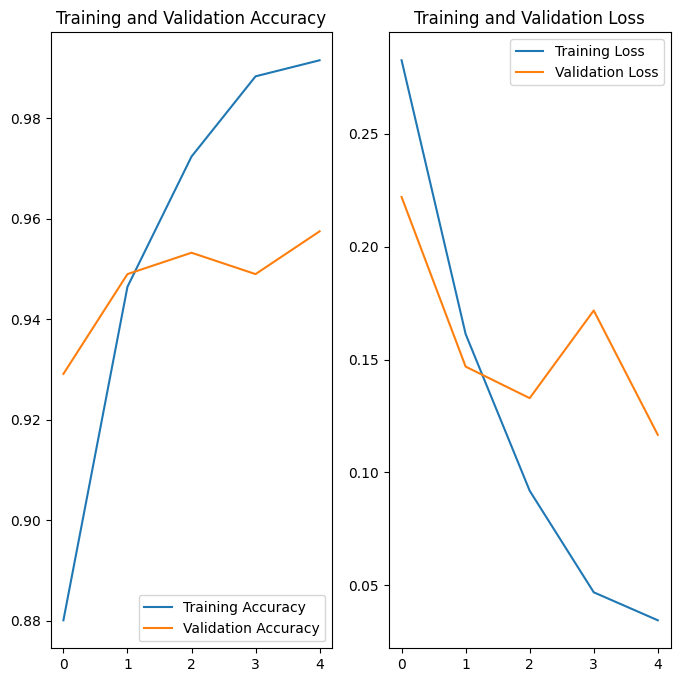

In [59]:
import matplotlib.pyplot as plt
epochs_range=range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_accuracy, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [122]:
model.evaluate(test_encoded, y_test)

56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - acc: 0.9825 - loss: 0.0999


[0.09985845535993576, 0.9825253486633301]

In [60]:
model.evaluate(test_encoded, y_test)

56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - acc: 0.9718 - loss: 0.0978


[0.09784015268087387, 0.9718151092529297]

In [123]:
prediction=model.predict(test_encoded)

56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step


In [124]:
prediction

array([[9.8125276e-04],
       [5.3475458e-02],
       [2.2394976e-04],
       ...,
       [4.8956927e-06],
       [1.9807835e-08],
       [4.1175287e-04]], shape=(1774, 1), dtype=float32)

In [126]:
p=np.where(prediction>0.5,1,0)

In [127]:
print(classification_report(y_test, p))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1542
           1       0.98      0.88      0.93       232

    accuracy                           0.98      1774
   macro avg       0.98      0.94      0.96      1774
weighted avg       0.98      0.98      0.98      1774



In [147]:
print(classification_report(y_test, p))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1542
           1       0.99      0.93      0.96       232

    accuracy                           0.99      1774
   macro avg       0.99      0.96      0.98      1774
weighted avg       0.99      0.99      0.99      1774



In [151]:
lb.classes_

array(['ham', 'spam'], dtype=object)

In [191]:
def predict_char_embd(text):
    text_v = np.zeros((1, longest_input, unique_chars))
    for i, token in enumerate(text):
        if i>longest_input:#>= to work on long text
            break
        text_v[0, i] = char2idx[token]
    # predict the input 
    prediction = model.predict(text_v)
    p=np.where(prediction>0.5,1,0)
    label = lb.classes_[p]
    return label

In [192]:
predict_char_embd("how mcuh for the french course hack hack hack >>>>> ?")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


array([['ham']], dtype=object)

In [193]:
x=x_train.iloc[50].message

x=x+x+x+x+x+x

len(x)

342

In [194]:
predict_char_embd(x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


array([['ham']], dtype=object)

In [195]:

x=x+x+x+x+x+x

len(x)

2052

In [196]:
predict_char_embd(x)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


array([['ham']], dtype=object)